# **Sentiment Analysis**

Towards Data Science tutorial: https://towardsdatascience.com/twitter-data-collection-tutorial-using-python-3267d7cfa93e

**Description:** 

This is a sentiment analysis program that parses the tweets fetched from Twitter using Python.

## **1.   Introduction: Importing libraries and set Twitter API**

In [ ]:
# Import all needed libraries
import tweepy                   # Python wrapper around Twitter API
from google.colab import drive  # to mount Drive to Colab notebook

import pandas as pd
pd.set_option('display.max_colwidth', None) #to see more text
import json 
import csv
from datetime import date
from datetime import datetime
import time
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()

from textblob import TextBlob
from wordcloud import WordCloud
import string
import itertools
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Connect Google Drive to Colab
drive.mount('/content/gdrive')
# Create a variable to store the data path on your drive
path = './gdrive/My Drive/path/to/data'

Mounted at /content/gdrive


In [ ]:
# Twitter API credentials

api_key = 'vpBT5zCco120S5VkWGeq0jbU3'
api_secret_key = 'nIk59NQikAS9kug5GcOkWuEqOqbAr1UgRhn5H77T9OiCdeEo7m'
access_token = '1362326919157583873-3NVcDUiiEBUsZGe06A7HzCTAs1tEDb'
access_token_secret = 'Y0Wrzi23jYd0TiAe9tNqQHax3PFqBrPRg2N2KQCl0rVtJ'


In [ ]:
# Connect to Twitter API using the secrets
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# Helper function to save data into a JSON file
# file_name: the file name of the data on Google Drive
# file_content: the data you want to save
def save_json(file_name, file_content):
  with open(path + file_name, 'w', encoding='utf-8') as f:
    json.dump(file_content, f, ensure_ascii=False, indent=4)

In [ ]:
# Helper function to handle twitter API rate limit
def limit_handled(cursor, list_name):
  while True:
    try:
      yield cursor.next()
    # Catch Twitter API rate limit exception and wait for 15 minutes
    except tweepy.RateLimitError:
      print("\nData points in list = {}".format(len(list_name)))
      print('Hit Twitter API rate limit.')
      for i in range(3, 0, -1):
        print("Wait for {} mins.".format(i * 5))
        time.sleep(5 * 60)
    # Catch any other Twitter API exceptions
    except tweepy.error.TweepError:
      print('\nCaught TweepError exception' )

## **2.   The functions to get Tweets, Followers, Followings and Stats**


In [ ]:
# Helper function to get all tweets of a specified user
# NOTE:This method only allows access to the most recent 3200 tweets
# Source: https://gist.github.com/yanofsky/5436496
def get_all_tweets(screen_name):
  # initialize a list to hold all the Tweets
  alltweets = []
  # make initial request for most recent tweets 
  # (200 is the maximum allowed count)
  new_tweets = api.user_timeline(screen_name = screen_name,count=200)
  # save most recent tweets
  alltweets.extend(new_tweets)
  # save the id of the oldest tweet less one to avoid duplication
  oldest = alltweets[-1].id - 1
  # keep grabbing tweets until there are no tweets left
  while len(new_tweets) > 0:
    print("getting tweets before %s" % (oldest))
    # all subsequent requests use the max_id param to prevent
    # duplicates
    new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
    # save most recent tweets
    alltweets.extend(new_tweets)
    # update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    print("...%s tweets downloaded so far" % (len(alltweets)))
    ### END OF WHILE LOOP ###
  # transform the tweepy tweets into a 2D array that will 
  # populate the csv
  outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count,tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
  # write the csv
  with open(path + '%s_tweets.csv' % screen_name, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["id","created_at","text","likes","in reply to","retweeted"])
    writer.writerows(outtweets)
  pass

In [ ]:
# Function to save follower objects in a JSON file.
def get_followers():
  
  # Create a list to store follower data
  followers_list = []
  # For-loop to iterate over tweepy cursors
  cursor = tweepy.Cursor(api.followers, count=200).pages()
  for i, page in enumerate(limit_handled(cursor, followers_list)):  
    print("\r"+"Loading"+ i % 5 *".", end='')
    
    # Add latest batch of follower data to the list
    followers_list += page
  
  # Extract the follower information
  followers_list = [x._json for x in followers_list]
  # Save the data in a JSON file
  save_json('followers_data.json', followers_list)

In [ ]:
# Function to save friend objects in a JSON file.
def get_friends():
  
  # Create a list to store friends data
  friends_list = []
  # For-loop to iterate over tweepy cursors
  cursor = tweepy.Cursor(api.friends, count=200).pages()
  for i, page in enumerate(limit_handled(cursor, friends_list)):  
    print("\r"+"Loading"+ i % 5 *".", end='')
    
    # Add latest batch of friend data to the list
    friends_list += page
  
  # Extract the friends information
  friends_list = [x._json for x in friends_list]
  # Save the data in a JSON file
  save_json('friends_data.json', friends_list)

In [ ]:
# Function to save daily follower and following counts in a JSON file
def todays_stats(dict_name):
  # Get my account information
  info = api.me()
  # Get follower and following counts
  followers_cnt = info.followers_count  
  following_cnt = info.friends_count
  # Get today's date
  today = date.today()
  d = today.strftime("%b %d, %Y")
  # Save today's stats only if they haven't been collected before
  if d not in dict_name:
    dict_name[d] = {"followers":followers_cnt, "following":following_cnt}
    save_json("follower_history.json", dict_name)
  else:
    print('Today\'s stats already exist')

## **3.   Specific application to my Case Study: Luxury Brand**

In [ ]:
# initialize a list to hold all the Tweets
alltweets = []
# make initial request for most recent tweets 
# (200 is the maximum allowed count)
new_tweets = api.user_timeline(screen_name = "Gucci",count=200)
# save most recent tweets
alltweets.extend(new_tweets)
# save the id of the oldest tweet less one to avoid duplication
oldest = alltweets[-1].id - 1
# keep grabbing tweets until there are no tweets left
while len(new_tweets) > 0:
  print("getting tweets before %s" % (oldest))
  # all subsequent requests use the max_id param to prevent
  # duplicates
  new_tweets = api.user_timeline(screen_name = "Gucci",count=200,max_id=oldest)
  # save most recent tweets
  alltweets.extend(new_tweets)
  # update the id of the oldest tweet less one
  oldest = alltweets[-1].id - 1
  print("...%s tweets downloaded so far" % (len(alltweets)))
  ### END OF WHILE LOOP ###

# transform the tweepy tweets into a df 
# populate the csv
outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count,tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
# create df
dftweets = pd.DataFrame(outtweets, columns=["id","created_at","text","likes","in reply to","retweeted"])
dftweets.head()

getting tweets before 1432387647981244419
...400 tweets downloaded so far
getting tweets before 1400120021964136457
...600 tweets downloaded so far
getting tweets before 1371264870512009219
...800 tweets downloaded so far
getting tweets before 1334485614457184256
...1000 tweets downloaded so far
getting tweets before 1313482595578019841
...1200 tweets downloaded so far
getting tweets before 1281679589052473344
...1400 tweets downloaded so far
getting tweets before 1252191033309499396
...1600 tweets downloaded so far
getting tweets before 1227254961387405311
...1800 tweets downloaded so far
getting tweets before 1210304303421939733
...2000 tweets downloaded so far
getting tweets before 1185820553996853247
...2200 tweets downloaded so far
getting tweets before 1166025010257022978
...2400 tweets downloaded so far
getting tweets before 1142073969790652415
...2600 tweets downloaded so far
getting tweets before 1126607397324316671
...2800 tweets downloaded so far
getting tweets before 110557

,id,created_at,text,likes,in reply to,retweeted
0,1456154392013402116,2021-11-04 07:00:35,".@Lizzo attended #GucciLoveParade wearing a Gucci Interlocking G coat, mini GG canvas slingbacks, a #GucciDiana min… https://t.co/kg04qfr71k",584,None,False
1,1456100940386349056,2021-11-04 03:28:11,".@thisismaneskin, the Italian band atop global charts and stars of the #GucciAria campaign, wore #GucciTailoring lo… https://t.co/mi6VMsR8iz",1979,None,False
2,1456005913261707264,2021-11-03 21:10:35,"In a moment of déjà new at #GucciLoveParade, @GwynethPaltrow wore #AlessandroMichele’s #GucciAria rendition of the… https://t.co/0SzwKiXfJT",633,None,False
3,1455952601413918721,2021-11-03 17:38:45,"""I thought...about the indefeasible gift of dreaming and the mythopoetic aura of cinema. This is why I chose Hollyw… https://t.co/SHvfzUC5z3",869,None,False
4,1455737984507125766,2021-11-03 03:25:56,"Spotted on Hollywood Boulevard for #GucciLoveParade - @Diane_Keaton, who recently starred in our #GucciBeloved campaign #DianeKeaton",301,None,False


In [ ]:
dftweets.shape

(3251, 6)

In [ ]:
# Clean the text

# Create a function to clean the tweets

def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) #Revoming @mentions
  text = re.sub(r'#', '', text) # Removing the '#' simbol
  text = re.sub(r'RT[\s]+', '', text) # Removing RT
  text = re.sub(r'https?:\/\/\S+', '', text) # Removing the hyper link
  text = text.lower() # make text lowercase
  text = re.sub('\[.*?\]', '', text) # removing text within brackets
  text = re.sub('\(.*?\)', '', text) # removing text within parentheses
  text = re.sub('\w*\d\w*', '', text) # removing numbers
  text = re.sub('\s+', ' ', text) # if there's more than 1 whitespace, then make it just 1
  text = re.sub('\n', ' ', text) # if there's a new line, then make it a whitespace
  text = re.sub('\"+', '', text) # removing any quotes
  text = re.sub('(\&amp\;)', '', text) # removing &amp;
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Get rid of all punctuation
  text = re.sub('(httptco)', '', text) # getting rid of `httptco`
  text = re.sub(r'[^\w\s]', '',text) # remove other punctuation

  return text

# Cleaning the text
dftweets['text'] = dftweets['text'].apply(cleanTxt)

# Show the cleaned text
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted
0,1456154392013402116,2021-11-04 07:00:35,attended gucciloveparade wearing a gucci interlocking g coat mini gg canvas slingbacks a guccidiana min,584,None,False
1,1456100940386349056,2021-11-04 03:28:11,the italian band atop global charts and stars of the gucciaria campaign wore guccitailoring lo,1979,None,False
2,1456005913261707264,2021-11-03 21:10:35,in a moment of déjà new at gucciloveparade wore alessandromicheles gucciaria rendition of the,633,None,False
3,1455952601413918721,2021-11-03 17:38:45,i thoughtabout the indefeasible gift of dreaming and the mythopoetic aura of cinema this is why i chose hollyw,869,None,False
4,1455737984507125766,2021-11-03 03:25:56,spotted on hollywood boulevard for gucciloveparade who recently starred in our guccibeloved campaign dianekeaton,301,None,False


In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create two new columns
dftweets['Subjectivity'] = dftweets['text'].apply(getSubjectivity)
dftweets['Polarity'] = dftweets['text'].apply(getPolarity)

# Show the new dataframe with the new columns
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted,Subjectivity,Polarity
0,1456154392013402116,2021-11-04 07:00:35,attended gucciloveparade wearing a gucci interlocking g coat mini gg canvas slingbacks a guccidiana min,584,None,False,0.000000,0.000000
1,1456100940386349056,2021-11-04 03:28:11,the italian band atop global charts and stars of the gucciaria campaign wore guccitailoring lo,1979,None,False,0.000000,0.000000
2,1456005913261707264,2021-11-03 21:10:35,in a moment of déjà new at gucciloveparade wore alessandromicheles gucciaria rendition of the,633,None,False,0.454545,0.136364
3,1455952601413918721,2021-11-03 17:38:45,i thoughtabout the indefeasible gift of dreaming and the mythopoetic aura of cinema this is why i chose hollyw,869,None,False,0.000000,0.000000
4,1455737984507125766,2021-11-03 03:25:56,spotted on hollywood boulevard for gucciloveparade who recently starred in our guccibeloved campaign dianekeaton,301,None,False,0.250000,0.000000


## **4.   Sentiment Analysis**

<function matplotlib.pyplot.show>

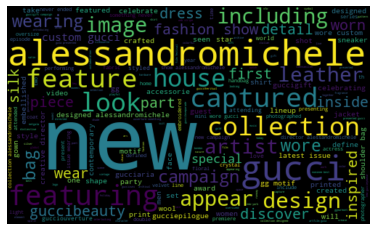

In [ ]:
# Plot the Word Cloud
allWords = ' '.join( [twts for twts in dftweets['text']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [ ]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

dftweets['Analysis'] = dftweets['Polarity'].apply(getAnalysis)

# Show the dataframe
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted,Subjectivity,Polarity,Analysis
0,1456154392013402116,2021-11-04 07:00:35,attended gucciloveparade wearing a gucci interlocking g coat mini gg canvas slingbacks a guccidiana min,584,None,False,0.000000,0.000000,Neutral
1,1456100940386349056,2021-11-04 03:28:11,the italian band atop global charts and stars of the gucciaria campaign wore guccitailoring lo,1979,None,False,0.000000,0.000000,Neutral
2,1456005913261707264,2021-11-03 21:10:35,in a moment of déjà new at gucciloveparade wore alessandromicheles gucciaria rendition of the,633,None,False,0.454545,0.136364,Positive
3,1455952601413918721,2021-11-03 17:38:45,i thoughtabout the indefeasible gift of dreaming and the mythopoetic aura of cinema this is why i chose hollyw,869,None,False,0.000000,0.000000,Neutral
4,1455737984507125766,2021-11-03 03:25:56,spotted on hollywood boulevard for gucciloveparade who recently starred in our guccibeloved campaign dianekeaton,301,None,False,0.250000,0.000000,Neutral


In [ ]:
# Print all of the positive tweets
j=1
sortedDF = dftweets.sort_values(by=['Polarity'])
for i in range(0, 20):
  if (sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') ' + sortedDF['text'][i])
    print()
    j = j+1

1) in a moment of déjà new at gucciloveparade wore alessandromicheles gucciaria rendition of the 

2) watch gucciloveparade live from hollywood boulevard 

3) hi and  welcome to gucciloveparade lizzo kimgordon

4)  and have arrived to attend the gucciloveparade fashion show streaming live at pt

5) kicking off our live coverage of guest arrivals at gucciloveparade in los angeles the livestream of the fashion s 



In [ ]:
# Print the negative tweets
j=1
sortedDF = dftweets.sort_values(by=['Polarity'], ascending='False')
for i in range(0, 20):
  if (sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') ' + sortedDF['text'][i])
    print()
    j = j+1

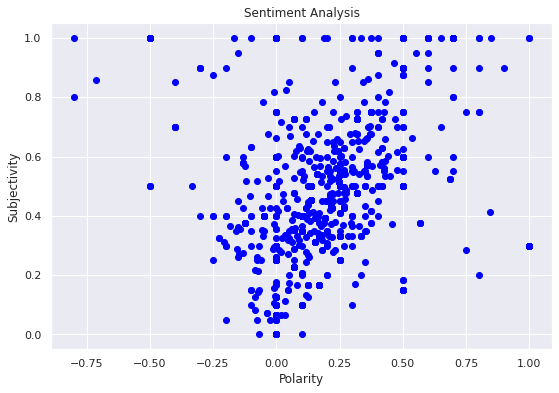

In [ ]:
# Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, 1788):
  plt.scatter(dftweets['Polarity'][i], dftweets['Subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
# Get the percentage of positive tweets
ptweets = dftweets[dftweets.Analysis == 'Positive']
ptweets = ptweets['text']

# Get the percentage of neutral tweets
nutweets = dftweets[dftweets.Analysis == 'Neutral']
nutweets = nutweets['text']

# Get the percentage of negative tweets
ngtweets = dftweets[dftweets.Analysis == 'Negative']
ngtweets = ngtweets['text']


print("% of positive tweets: ", round((ptweets.shape[0] / dftweets.shape[0])*100, 1))
print("% of neutral tweets: ", round((nutweets.shape[0] / dftweets.shape[0])*100, 1))
print("% of negative tweets: ", round((ngtweets.shape[0] / dftweets.shape[0])*100, 1))

% of positive tweets:  48.9
% of neutral tweets:  44.2
% of negative tweets:  6.9


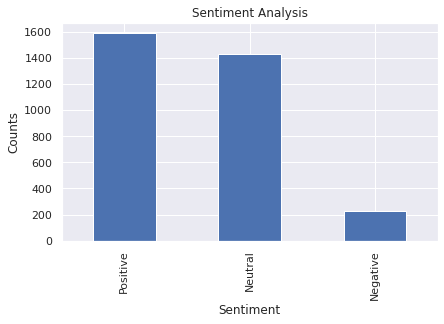

In [ ]:
# Show the value counts
dftweets['Analysis'].value_counts()

# Plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
dftweets['Analysis'].value_counts().plot(kind='bar')
plt.show()

We can confirm the importance of neutral speech in Twitter textual data here. We can see that almost half of Tweets represents neutral speech. It makes sense since Luxury Brands tend to not use typical positive marketing speech. 

## **5.   Save DataFrame**

In [ ]:
dftweets.to_csv('/content/gdrive/MyDrive/Final Project/NLP/GucciTweets.csv', index=False)

# **Advanced NLP**

We can now perform advanced NLP on the dataset. It is composed of 3k tweets that have the following analysis: Positive Speech, Neutral Speech, Negative Speech. 

## **1.   Introduction: Importing libraries and Look at Data**



In [ ]:
%%capture

# Install all needed libraries

!pip install tweet-preprocessor -qq
!pip install eli5 -qq
!pip install textstat -qq

In [ ]:
%%capture

# Import all needed libraries
import nltk 
nltk.download('punkt') 
nltk.download('stopwords') 
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
from nltk.stem import WordNetLemmatizer, PorterStemmer

import preprocessor as prepro 
import spacy
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
tweet = pd.read_csv('/content/drive/MyDrive/Final Project/GucciTweets.csv')

tweet.head()

,id,created_at,text,likes,in reply to,retweeted,Subjectivity,Polarity,Analysis
0,1455295050737410055,2021-11-01 22:05:52,"On the second night of Harryween, and his band dressed up as clowns in custom Gucci looks by…",11527,NaN,False,0.00,0.000,Neutral
1,1455294919992565760,2021-11-01 22:05:21,JayZ was inducted into the Rock &amp; Roll Hall of Fame wearing a Gucci dark blue satin tuxedo with evening shirt and…,555,NaN,False,0.25,-0.075,Negative
2,1454921548721238019,2021-10-31 21:21:43,"For his Harryween concert, and members of his band dressed up as characters from the book ‘The Wonder…",22728,NaN,False,0.00,0.000,Neutral
3,1454840726290776069,2021-10-31 16:00:33,A brush with divinity\nStay tuned for GucciLoveParade AlessandroMichele,537,NaN,False,0.00,0.000,Neutral
4,1454342435807584264,2021-10-30 07:00:31,Coming soon to a Boulevard near you on November 2 at 8pm. GucciLoveParade AlessandroMichele\n© Universal City Stud…,993,NaN,False,0.20,0.050,Positive


As you can see Positive Speech has a slightly higher distribution than the Neutral Speech. The tweets are mostly composed of Positive and Neutral Speech, Negative speech is not significant. 

In [ ]:
# Remove Negative speech for the Analysis Neutral/Positive
tweet = tweet[(tweet['Analysis'] != 'Negative')]
tweet.Analysis.unique()

array(['Neutral', 'Positive'], dtype=object)

In [ ]:
# Encode Analysis values: 0 for Neutral and 1 for Positive
tweet['Analysis'].replace({'Neutral': 0, 'Positive': 1}, inplace=True)

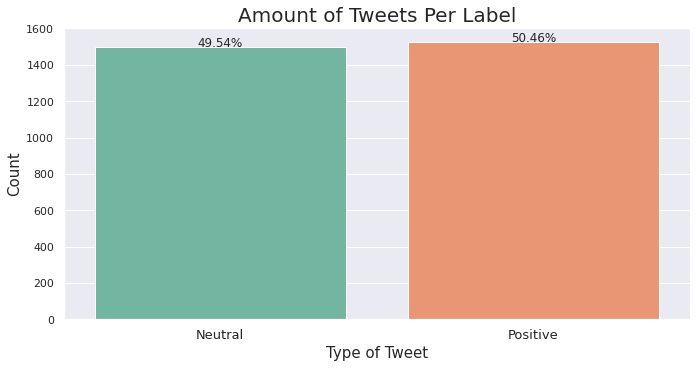

In [ ]:
# Look at the distribution again
plt.figure(figsize = (10,5))
ax = sns.countplot(tweet['Analysis'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20) 
ax.set_xlabel('Type of Tweet',fontsize = 15) 
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Neutral','Positive'],fontsize = 13)

total = float(len(tweet)) # one person per row 
for p in ax.patches:
    height = p.get_height() 
    ax.text(p.get_x()+p.get_width()/2.,
        height + 3,
        '{:1.2f}'.format(height/total * 100) + '%', 
        ha="center")

We can see that the difference of distribution is really small between the two labels.

## **2.   Creation of a new and more clean dataset**



In [ ]:
# creating new dataframe `clean_tweet`
clean_tweet = tweet[['text','Analysis']].copy()
clean_tweet = clean_tweet.reindex(columns=['Analysis', 'text'])
clean_tweet.rename(columns={"Analysis": "label"}, inplace=True)

print(clean_tweet.shape)
print(clean_tweet.info())
clean_tweet.head()

(3028, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3028 entries, 0 to 3249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3028 non-null   int64 
 1   text    3025 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.0+ KB
None


,label,text
0,0,"On the second night of Harryween, and his band dressed up as clowns in custom Gucci looks by…"
2,0,"For his Harryween concert, and members of his band dressed up as characters from the book ‘The Wonder…"
3,0,A brush with divinity\nStay tuned for GucciLoveParade AlessandroMichele
4,1,Coming soon to a Boulevard near you on November 2 at 8pm. GucciLoveParade AlessandroMichele\n© Universal City Stud…
5,0,"Hollywood, here we come. MarilynMonroe GucciLoveParade AlessandroMichele Marilyn Monroe™; The Estate of Marilyn…"


In [ ]:
# Remove na values

clean_tweet.dropna(inplace=True)
clean_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3025 non-null   int64 
 1   text    3025 non-null   object
dtypes: int64(1), object(1)
memory usage: 70.9+ KB


In [ ]:
# appling data cleaning function to `tweet` column
clean_tweet['clean_tweets'] = clean_tweet['text'].apply(round1)

print(clean_tweet.shape)
clean_tweet.head()

(3025, 3)


,label,text,clean_tweets
0,0,"On the second night of Harryween, and his band dressed up as clowns in custom Gucci looks by…",on the second night of harryween and his band dressed up as clowns in custom gucci looks by
2,0,"For his Harryween concert, and members of his band dressed up as characters from the book ‘The Wonder…",for his harryween conce and members of his band dressed up as characters from the book the wonder
3,0,A brush with divinity\nStay tuned for GucciLoveParade AlessandroMichele,a brush with divinity stay tuned for gucciloveparade alessandromichele
4,1,Coming soon to a Boulevard near you on November 2 at 8pm. GucciLoveParade AlessandroMichele\n© Universal City Stud…,coming soon to a boulevard near you on november at gucciloveparade alessandromichele universal city stud
5,0,"Hollywood, here we come. MarilynMonroe GucciLoveParade AlessandroMichele Marilyn Monroe™; The Estate of Marilyn…",hollywood here we come marilynmonroe gucciloveparade alessandromichele marilyn monroe the estate of marilyn


## **3.   Tokenizing & Removing Stop Words**



In [ ]:
# assigning variables to essential columns
data = clean_tweet['clean_tweets'] 
target = clean_tweet['label']

In [ ]:
 # set stopwords
 stop_words = set(stopwords.words('english'))

In [ ]:
 # function to tokenize tweets and remove stop words with NLTK built-in library
def process_tweet(text):
  tokens = nltk.word_tokenize(text)
  stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words] 
  return stopwords_removed

In [ ]:
# Apply function
process_data = list(map(process_tweet, data))

In [ ]:
 # getting count of all unique words in the corpus
total_vocab = set()
for comment in process_data:
  total_vocab.update(comment) 
len(total_vocab)

6073

In [ ]:
# transforming `processed_data` into a readable list
flat_filtered = [item for sublist in process_data for item in sublist] # getting frequency distribution
clean_corpus_freqdist = FreqDist(flat_filtered)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('new', 729),
 ('gucci', 484),
 ('alessandromichele', 462),
 ('collection', 291),
 ('campaign', 288),
 ('featuring', 192),
 ('show', 192),
 ('captured', 181),
 ('wore', 167),
 ('bag', 162),
 ('wearing', 154),
 ('leather', 148),
 ('gg', 145),
 ('designed', 145),
 ('fashion', 141),
 ('house', 133),
 ('including', 122),
 ('features', 122),
 ('g', 113),
 ('issue', 111)]

## **4.   Most Frequent Words for Each Classification**

In [ ]:
# creating new dfs for each classification
tweet_freq_pos = clean_tweet[clean_tweet['label']==1] 
tweet_freq_neu = clean_tweet[clean_tweet['label']==0]

In [ ]:
# pulling out the text data for cleaned tweets
data_neu = tweet_freq_neu['clean_tweets'] 
data_pos = tweet_freq_pos['clean_tweets']

In [ ]:
# creating lists for processed neutral & positive data
process_neu = list(map(process_tweet, data_neu)) 
process_pos = list(map(process_tweet, data_pos))

In [ ]:
# exact amount of neutral speech
total_vocab_neu = set()
for comment in process_neu:
  total_vocab_neu.update(comment) 
len(total_vocab_neu)

3984

In [ ]:
# Most common neutral words
flat_neu = [item for sublist in process_neu for item in sublist] 
neu_freq = FreqDist(flat_neu)
neu_freq.most_common(20)

[('gucci', 267),
 ('alessandromichele', 238),
 ('wore', 129),
 ('show', 122),
 ('collection', 111),
 ('captured', 102),
 ('campaign', 101),
 ('featuring', 99),
 ('fashion', 89),
 ('gg', 83),
 ('wearing', 81),
 ('bag', 75),
 ('silk', 73),
 ('house', 71),
 ('leather', 68),
 ('including', 68),
 ('designed', 65),
 ('dress', 63),
 ('g', 58),
 ('pieces', 58)]

In [ ]:
# Most common positive words
flat_pos = [item for sublist in process_pos for item in sublist] 
pos_freq = FreqDist(flat_pos)
pos_freq.most_common(20)

[('new', 703),
 ('alessandromichele', 224),
 ('gucci', 217),
 ('campaign', 187),
 ('collection', 180),
 ('latest', 94),
 ('featuring', 93),
 ('special', 91),
 ('bag', 87),
 ('first', 87),
 ('leather', 80),
 ('designed', 80),
 ('captured', 79),
 ('wearing', 73),
 ('show', 70),
 ('creative', 69),
 ('features', 68),
 ('issue', 65),
 ('house', 62),
 ('gg', 62)]



*   *What are the linguistic differences between neutral speech and positive language?*



In [ ]:
# create counts of neutral and positive with values and words
neu_bar_counts = [x[1] for x in neu_freq.most_common(20)] 
neu_bar_words = [x[0] for x in neu_freq.most_common(20)]

pos_bar_counts = [x[1] for x in pos_freq.most_common(20)] 
pos_bar_words = [x[0] for x in pos_freq.most_common(20)]

Text(0.5, 0.98, 'Top 20 Most Frequent Words per Label')

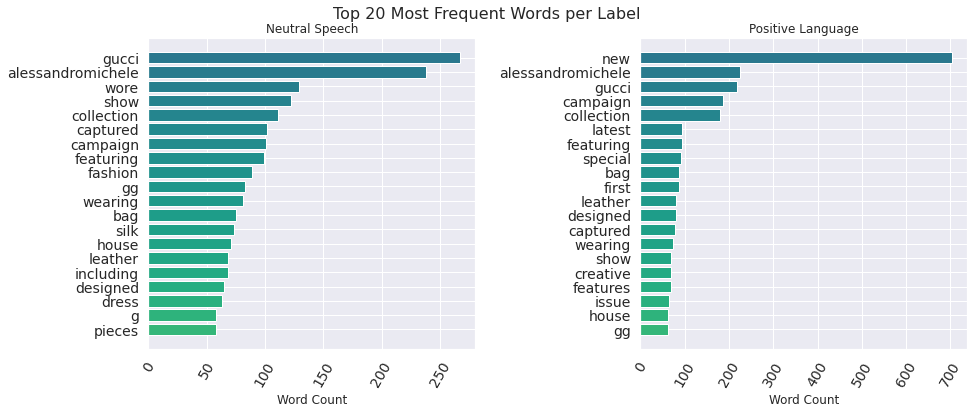

In [ ]:
 # set the color of the bar graphs
from matplotlib import cm
color = cm.viridis(np.linspace(.4,.8, 30))

new_figure = plt.figure(figsize=(14,6)) 

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# generating a bar chart on each axes
ax.barh(neu_bar_words, neu_bar_counts, color=color) 
ax2.barh(pos_bar_words, pos_bar_counts, color=color)

ax.title.set_text('Neutral Speech') 
ax2.title.set_text('Positive Language')

for ax in new_figure.axes: 
  plt.sca(ax)
  plt.xticks(rotation=60, fontsize=14)
  plt.xlabel("Word Count")
  plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

## **5.   Lemmanization**

In [ ]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []
for listy in process_data:
  lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy]) 
  lemmatized_output.append(lemmed)

In [ ]:
 X_lem = lemmatized_output 
 y_lem = target
# target is label

*   *Now X_lem and y_lem are contain cleaned text and the original labels, ready to be used for modeling.*



## **6.   Feature Engineering**

**TF-IDF Vectorization**

The most popular methods is TF-IDF Vectorization.
This is an acronym that stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

*   Term Frequency: This summarizes how often a given word appears within a document. 
*   Inverse Document Frequency: This down scales words that appear a lot across documents.

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across other documents.

In [ ]:
# import needed libraries 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# initial TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=42)

 # instantiating tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

 # transforming tokenized data into sparse matrix format with 3K stored elements
X_train_tfidf = tfidf.fit_transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# fit and evaluate LR model
model = LogisticRegression().fit(X_train_tfidf,y_train) 
y_preds_log = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds_log ) 
print(report)
acc=accuracy_score(y_test,y_preds_log) 
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       295
           1       0.90      0.86      0.88       310

    accuracy                           0.88       605
   macro avg       0.88      0.88      0.88       605
weighted avg       0.88      0.88      0.88       605

Logistic Regression, Accuracy Score: 0.8809917355371901


In [ ]:
# fit and evaluate XGB model
model_XGB = XGBClassifier().fit(X_train_tfidf,y_train) 
y_preds_xgb = model_XGB.predict(X_test_tfidf)
report = classification_report( y_test, y_preds_xgb) 
print(report)
acc2=accuracy_score(y_test,y_preds_xgb) 
print("XGboost, Accuracy Score:" , acc2)

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       295
           1       0.99      0.76      0.86       310

    accuracy                           0.87       605
   macro avg       0.89      0.88      0.87       605
weighted avg       0.90      0.87      0.87       605

XGboost, Accuracy Score: 0.8743801652892562


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f41c7f2a550>)

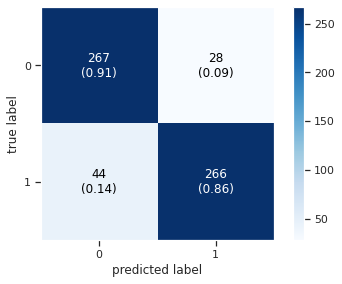

In [ ]:
# Confusion Matrix: Logistic Regression
confmatrix = confusion_matrix(y_test,y_preds_log)
plot_confusion_matrix(conf_mat=confmatrix, colorbar=True, show_absolute=True, show_normed=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f41c8042550>)

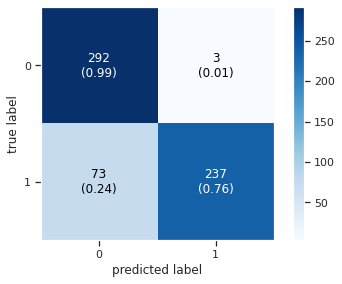

In [ ]:
# Confusion Matrix: XGBoost
confmatrix = confusion_matrix(y_test,y_preds_xgb)
plot_confusion_matrix(conf_mat=confmatrix, colorbar=True, show_absolute=True, show_normed=True)

For both Logistic Regression and XGBoost model the accuracy scores were quite high and Logistic Regression resulted as the best one. Logistic Regression outperform XGBoost on positive speech. 

## **7.   Weight of the words**

Here we do a quick analysis of the weights of each word in a single tweet.

In [ ]:
# Reload the dataset
tweet2 = pd.read_csv('/content/drive/MyDrive/Final Project/GucciTweets.csv')

tweet2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3250 non-null   int64  
 1   created_at    3250 non-null   object 
 2   text          3247 non-null   object 
 3   likes         3250 non-null   int64  
 4   in reply to   25 non-null     object 
 5   retweeted     3250 non-null   bool   
 6   Subjectivity  3250 non-null   float64
 7   Polarity      3250 non-null   float64
 8   Analysis      3250 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(4)
memory usage: 206.4+ KB


In [ ]:
# Cleaning data
tweet2.drop(columns='in reply to', axis=1, inplace=True)
tweet2.dropna(inplace=True)

tweet2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3247 entries, 0 to 3249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3247 non-null   int64  
 1   created_at    3247 non-null   object 
 2   text          3247 non-null   object 
 3   likes         3247 non-null   int64  
 4   retweeted     3247 non-null   bool   
 5   Subjectivity  3247 non-null   float64
 6   Polarity      3247 non-null   float64
 7   Analysis      3247 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 206.1+ KB


In [ ]:
# Preprocessing
prepro.set_options(prepro.OPT.URL, prepro.OPT.EMOJI, prepro.OPT.NUMBER, prepro.OPT.MENTION, prepro.OPT.RESERVED, prepro.OPT.SMILEY)
tweet2['text_clean'] = tweet2['text'].map(lambda t: prepro.clean(t))
tweet2['text_clean'] = tweet2['text_clean'].str.replace('#','')

In [ ]:
# Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(tweet2['text_clean'])
y = tweet2['Analysis']

X

<3247x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 43683 stored elements in Compressed Sparse Row format>

In [ ]:
# Define Preprocessing function
def tweet_preprocess(tweets):
  prepro_tweets = tweets.map(lambda t: prepro.clean(t))
  prepro_tweets = prepro_tweets.str.replace('#','')
  prepro_tweets = vectorizer.transform(prepro_tweets)
  
  return prepro_tweets

In [ ]:
# Define model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
model = LogisticRegression() 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
import eli5
eli5.show_weights(model, feature_names=vectorizer.get_feature_names(), target_names=['negative','neutral','positive'], top=20)

In [ ]:
eli5.show_prediction(model, tweet2['text_clean'][50], vec=vectorizer, target_names=['negative','neutral','positive'])